In [264]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as explain
import pyAgrum.lib.bn_vs_bn as bnvsbn

import pandas as pd

import numpy as np

from sklearn.datasets import fetch_california_housing

import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

In [43]:
df = pd.concat([X,y], axis=1)

In [164]:
attr_inf = """
        MedInc: median income in block group

        HouseAge: median house age in block group

        AveRooms: average number of rooms per household

        AveBedrms: average number of bedrooms per household

        Population: block group population

        AveOccup: average number of household members

        Latitude: block group latitude

        Longitude: block group longitude
"""

print(attr_inf)

df.describe()


        MedInc: median income in block group

        HouseAge: median house age in block group

        AveRooms: average number of rooms per household

        AveBedrms: average number of bedrooms per household

        Population: block group population

        AveOccup: average number of household members

        Latitude: block group latitude

        Longitude: block group longitude



,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### Model building: Bayesian Network
We'll start by building multiple <b> conditional probability tables </b>. A Bayesian Network could be (imo should be) viewed as a big relational conditional probability model <br>
which utilizes the tables of conditional probabilities for inference.

In [237]:
# Define a function which takes as input a pandas dataframe
# creates new boolean columns and drops the old columns

def cutter(input):
    data = input.copy()
    
    cols = data.columns.drop(list(filter(lambda col: "L" in col, data.columns))) # Drop Latitude and Longitude cols
    labels = [0, 1]
    
    
    for col in cols:
        qbins = [data[col].quantile(0.25), data[col].quantile(0.5)]
        data[col + "_bool"] = [labels[0] if data[col].iloc[i] < qbins[0] else labels[1] for i in range(len(data[col]))] # Should create new columns iteratively
        
    keep_cols = (list(filter(lambda col: "_bool" in col, data.columns)))
    data = data[keep_cols]
    return data

In [240]:
df_bools = cutter(df) # Boolean columns in a pandas dataframe

In [241]:
df_bools.columns

Index(['MedInc_bool', 'HouseAge_bool', 'AveRooms_bool', 'AveBedrms_bool',
       'Population_bool', 'AveOccup_bool', 'MedHouseVal_bool'],
      dtype='object')

In [247]:
pd.crosstab(df_bools.MedInc_bool, df_bools.HouseAge_bool)

HouseAge_bool,0,1
MedInc_bool,,
0,832,4328
1,3924,11556


In [250]:
# Given that HouseAge_bool is less than the median, what is the probability that MedInc_bool is less than or equal/higher than the median?

pd.crosstab(df_bools.MedInc_bool, df_bools.HouseAge_bool)[0] / pd.crosstab(df_bools.MedInc_bool, df_bools.HouseAge_bool).sum(axis=0)[0] 

MedInc_bool
0    0.174937
1    0.825063
Name: 0, dtype: float64

### Utilizing pyagrum functionality
Instead of us building the conditional probability tables we can use pyagrums nice features which allows <br>
us to learn the parameters (nodes) of a dataset. <br>
<br>
*I do not recommend learning the probability nodes if you don't know anything about the underlying problem you are trying to solve*

In [261]:
bn_learn = gum.BNLearner(df_bools)
bn_learn

(pyAgrum.BNLearner<double>@0x14e8b5dd0d0) Filename       : C:\Users\jako\AppData\Local\Temp\tmpaiw1tsbi.csv
Size           : (20640,7)
Variables      : MedInc_bool[2], HouseAge_bool[2], AveRooms_bool[2], AveBedrms_bool[2], Population_bool[2], AveOccup_bool[2], MedHouseVal_bool[2]
Induced types  : True
Missing values : False
Algorithm      : Greedy Hill Climbing
Score          : BDeu
Correction     : MDL  (Not used for score-based algorithms)
Prior          : -

In [262]:
bn_model = bn_learn.learnBN()

### Causal relationships
Now what we see in the DAG below is that each of the vertices are unidirectional and not acyclical. <br>
This allows us to define it as a Directed Acyclic Graph (DAG for short). <br>
Judea Pearl mentions in "The Book of Why" that these relationships could be interpreted as "*<b>may</b> have a causal relationship* "on the node it points at. <br>
<br>
As a trained Statistician, I find the explanation reasonably well defined. We don't know if it causes it but it *may* have that influence on it.

In [265]:
bn_model

(pyAgrum.BayesNet<double>@0x14e8b169940) BN{nodes: 7, arcs: 16, domainSize: 128, dim: 58, mem: 928o}

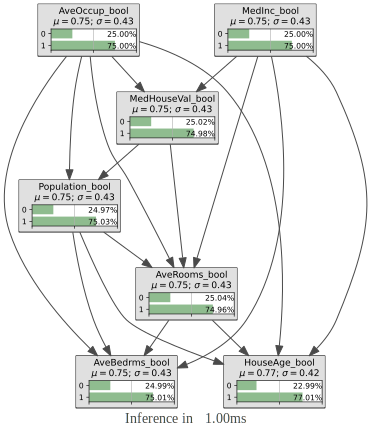

In [280]:
gnb.showInference(bn_model) # This is our model exposed with probabilities

## Counterfactuals
What I love about Bayesian Networks is that we can do counterfactual reasoning about some problem we face. <br>
We might have parameters we observe directly and some we observe later on after some time-lag or event. <br>
What we can do prior to the event is playing with counterfactuals. <br>
<br>
Assume that we can only observe *Average Rooms* after we've collected data on the *Median Income*.<br>
Also assume that we observed that the area we are in has a *Median Income* higher than the median (MedInc=1).<br>
<br>

The probability of *Average Rooms* being above the median, given that *Median Income* is higher than the median, increased to 84%.<br>
Now let's reverse it. What will the other parameters look like if *Average Rooms* are higher than the median.

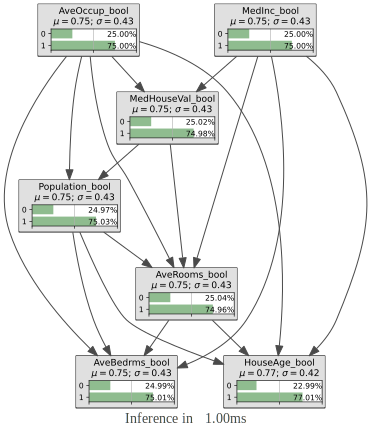

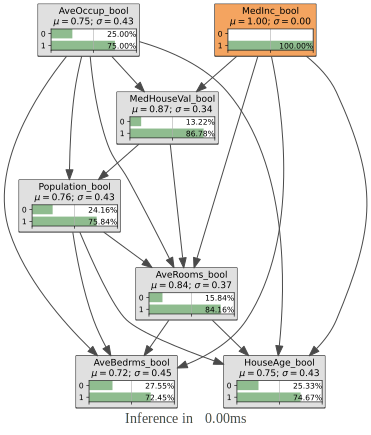

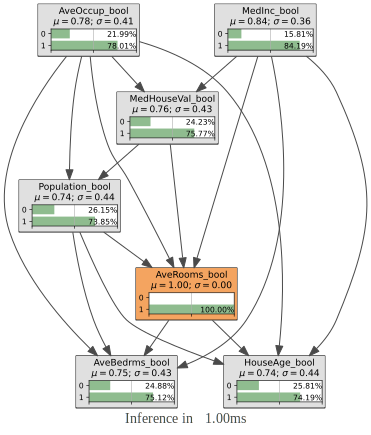

None,None,None


In [285]:
# gnb.showInference(bn_model, evs={"MedInc_bool": 1}) 
gnb.sideBySide(gnb.showInference(bn_model) , gnb.showInference(bn_model, evs={"MedInc_bool": 1}), gnb.showInference(bn_model, evs={"AveRooms_bool": 1})  )